Итак, в л/р №1 рассматривались различные методы снижения размерности пространства признаков для решения задачи кластеризации. Нашим фаворитом оказался UMAP 3D для картинок 8 на 8 пикселей, n_neighbors должен быть в районе дефолтного значения (40). Именно эти исходные данные давали наибольший ARI при применении к ним агломеративной кластеризации с метрикой euclidean и функцией связи average. Воспроизведём это достижение.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import sklearn.datasets

images, target = sklearn.datasets.load_digits(return_X_y=True, as_frame=True)
print(images.shape)

(1797, 64)


In [ ]:
import numpy as np

X, y_true = images, target.astype(int)
X = X.astype(np.float32) / 255.0

In [ ]:
import umap
!pip install umap-learn[plot]
import umap.plot
from umap import UMAP
import time
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 56.6 MB/s eta 0:00:00


In [ ]:
from sklearn.metrics.pairwise import pairwise_distances

def evaluate_clustering(X, y_true, distance_threshold, metric='euclidean', linkage='ward'):
    clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=distance_threshold, metric=metric, linkage=linkage)

    start = time.process_time()
    y_pred = clustering.fit_predict(X)
    diff = time.process_time() - start

    n_clusters = len(np.unique(y_pred))

    return y_pred, n_clusters, {
        'Time': diff,
        'ARI': adjusted_rand_score(y_true, y_pred),
    }

def find_optimal_clustering(X, y_true, metric='euclidean', linkage='ward', iterations=1000):
    optimal_threshold = None
    best_metrics = None
    y_optimal = None
    n_clusters_optimal = None

    dist = pairwise_distances(X, metric=metric)

    for threshold in np.linspace(np.min(dist), np.max(dist), iterations):
        #print(threshold, metric, linkage)
        y_pred, n_clusters, metrics = evaluate_clustering(dist, y_true, threshold, 'precomputed', linkage)

        ari = metrics['ARI']
        if best_metrics is None or ari > best_metrics['ARI']:
            best_metrics = metrics
            y_optimal = y_pred
            optimal_threshold = threshold
            n_clusters_optimal = n_clusters

    return optimal_threshold, best_metrics, y_optimal, n_clusters_optimal

In [ ]:
import seaborn as sns

def plot_clustering_heatmap(X, y_true):
  distances = ['euclidean', 'manhattan', 'cosine']
  linkages = ['complete', 'average', 'single']

  time, ari, n_clusters = np.ndarray((len(distances), len(linkages))), np.ndarray((len(distances), len(linkages))), np.ndarray((len(distances), len(linkages)))

  for i, metric in enumerate(distances):
    for j, linkage in enumerate(linkages):
      #print(metric, linkage)
      try:
        _, metrics, _, n = find_optimal_clustering(X, y_true, metric=metric, linkage=linkage, iterations=50)
        #print(metrics)
        time[i, j], ari[i, j], n_clusters[i, j] = metrics['Time'], metrics['ARI'], n
      except Exception as e:
        print(e)
        time[i, j], ari[i, j], n_clusters[i, j] = 0, 0, 0

  fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 4))
  sns.heatmap(time, ax=ax1, annot=True, cmap='Reds', xticklabels=linkages, yticklabels=distances)
  sns.heatmap(ari, ax=ax2, annot=True, cmap='Reds', xticklabels=linkages, yticklabels=distances)
  sns.heatmap(n_clusters, ax=ax3, annot=True, cmap='Reds', xticklabels=linkages, yticklabels=distances)
  ax1.set_title('Time')
  ax2.set_title('ARI score')
  ax3.set_title('Clusters count')
  plt.show()

In [ ]:
from sklearn.metrics import pairwise_distances
from collections import Counter
from mpl_toolkits import mplot3d
%matplotlib inline

def class_purity(y_true, y_pred, cls):
    class_mask = (y_true == cls)
    class_predictions = y_pred[class_mask]
    cluster_counts = Counter(class_predictions)
    purity = max(cluster_counts.values()) / len(class_predictions)
    return purity

def plot_clustering(title, X, y_true, y_pred, metric):
    fig, plots = plt.subplots(2, 2, figsize=(12,12))
    fig.suptitle(title)
    plt.prism()

    n_clusters = len(np.unique(y_true))
    purities = []

    ax = fig.add_subplot(2, 2, 1, projection='3d') if X.shape[1] == 3 else plots[0, 0]
    for i in range(n_clusters):
        digit_indices = (y_true == i)
        purities.append(class_purity(y_true, y_pred, i))
        dims = [X[digit_indices, i] for i in range(X.shape[1])]
        ax.set_title('Original')
        ax.scatter(*dims, label=f"Digit {i}")
        ax.legend()

    purities.append(np.average(purities))

    avg_dist = np.zeros((n_clusters, n_clusters))
    for i in range(n_clusters):
        for j in range(n_clusters):
            avg_dist[i, j] = pairwise_distances(
                X[y_true == i], X[y_true == j], metric=metric
            ).mean()
    avg_dist /= avg_dist.max()
    sns.heatmap(avg_dist, ax=plots[1, 0], annot=True, cmap='Reds', xticklabels=np.arange(n_clusters), yticklabels=np.arange(n_clusters))

    inner_distances = [avg_dist[i, i] for i in range(n_clusters)]
    inner_distances.append(np.average(inner_distances))
    sns.heatmap([inner_distances, purities], ax=plots[1, 1], annot=True, cmap='Reds', xticklabels=[*np.arange(n_clusters), 'avg'], yticklabels=['inner distance', 'purity'])

    n_clusters = len(np.unique(y_pred))

    ax = fig.add_subplot(2, 2, 2, projection='3d') if X.shape[1] == 3 else plots[0, 1]
    for i in range(n_clusters):
        digit_indices = (y_pred == i)
        dims = [X[digit_indices, i] for i in range(X.shape[1])]
        ax.set_title('Prediction')
        ax.scatter(*dims, label=f"Cluster {i}")
        ax.legend()

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

In [ ]:
umap_3d_embeddings = UMAP(n_components=3, random_state=7).fit_transform(X)

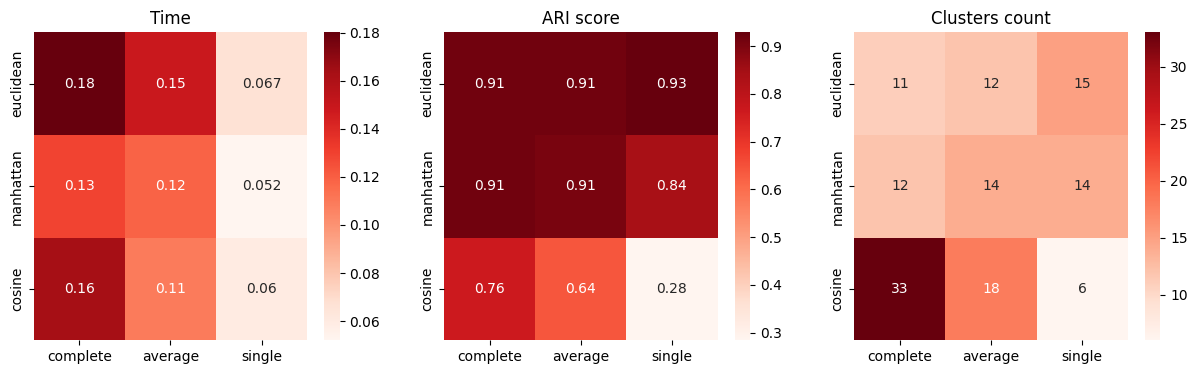

In [ ]:
plot_clustering_heatmap(umap_3d_embeddings, y_true)

In [ ]:
threshold, metrics, y_pred_best, n_clusters = find_optimal_clustering(umap_3d_embeddings, y_true, metric='euclidean', linkage='average')
print(metrics)

{'Time': 0.11748443700000166, 'ARI': 0.9138760822203242}


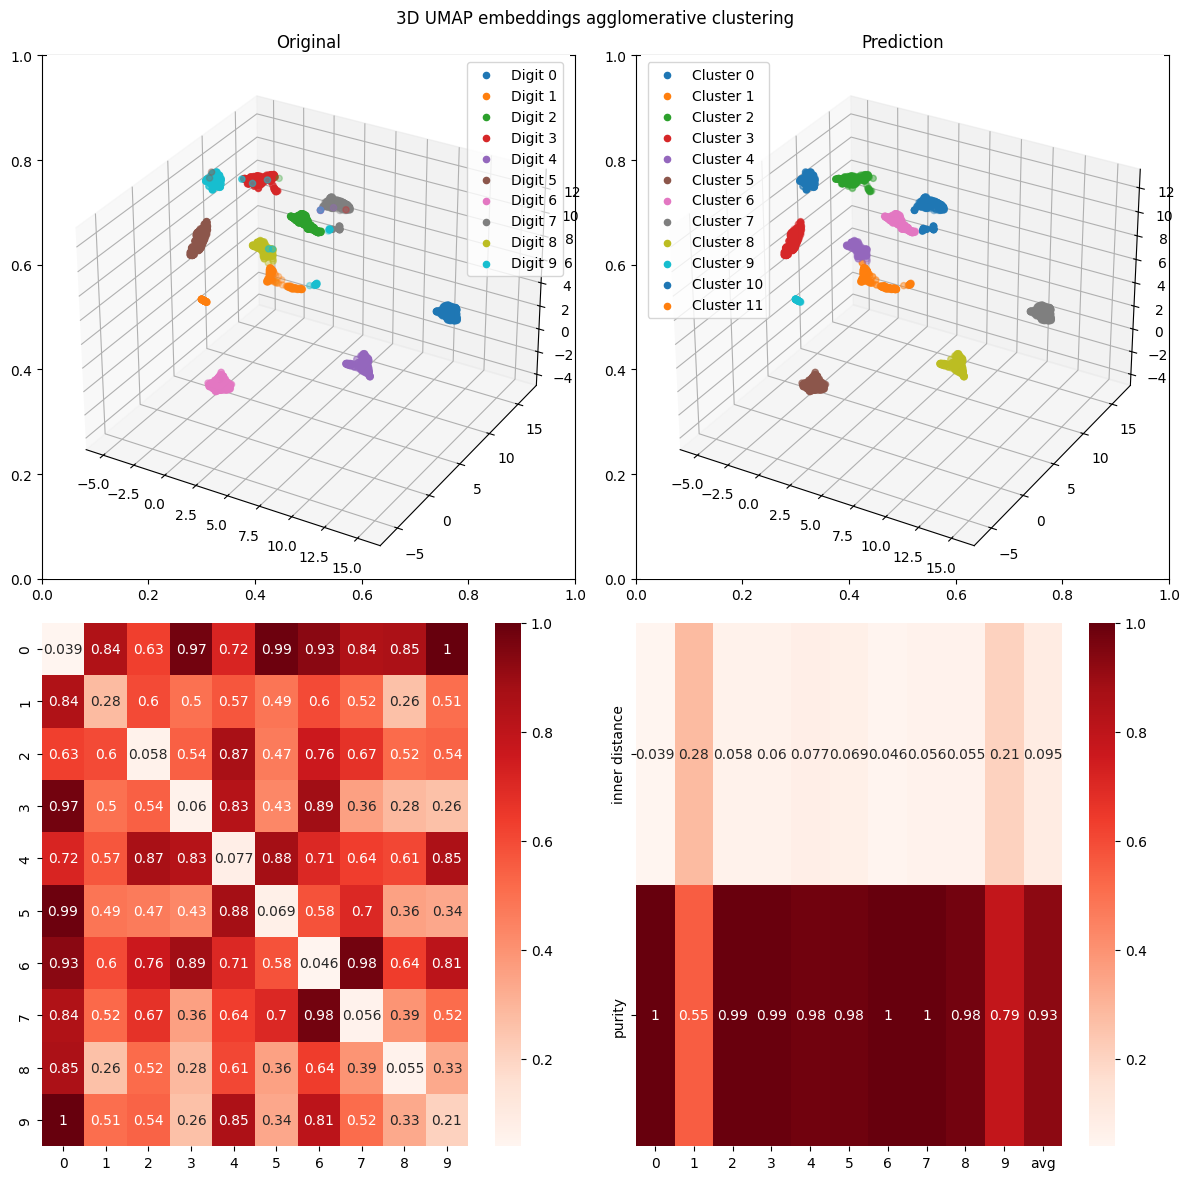

In [ ]:
plot_clustering('3D UMAP embeddings agglomerative clustering', umap_3d_embeddings, y_true, y_pred_best, 'euclidean')

Возьмём за основу этот результат и продолжим улучшать его, меняя алгоритм кластеризации.

In [ ]:
dbi_orig = davies_bouldin_score(X, y_true)
silhouette_orig = silhouette_score(X, y_true, random_state=7)
calinski_harabasz_orig = calinski_harabasz_score(X, y_true)

dbi_umap = davies_bouldin_score(umap_3d_embeddings, y_true)
silhouette_umap = silhouette_score(umap_3d_embeddings, y_true, random_state=7)
calinski_harabasz_umap = calinski_harabasz_score(umap_3d_embeddings, y_true)

dbi_scores = []
ari_scores = []
silhouette_scores = []
calinski_harabasz_scores = []

for k in range(2, 20):
  y_pred = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='average').fit_predict(umap_3d_embeddings)
  dbi_scores.append(davies_bouldin_score(umap_3d_embeddings, y_pred))
  ari_scores.append(adjusted_rand_score(y_true, y_pred))
  silhouette_scores.append(silhouette_score(umap_3d_embeddings, y_pred, random_state=7))
  calinski_harabasz_scores.append(calinski_harabasz_score(umap_3d_embeddings, y_pred))

print(f"Optimal clusters count (DBI):               {np.argmin(dbi_scores)+2}")
print(f"Optimal clusters count (ARI):               {np.argmax(ari_scores)+2}")
print(f"Optimal clusters count (Silhouette):        {np.argmax(silhouette_scores)+2}")
print(f"Optimal clusters count (Calinski Harabasz): {np.argmax(calinski_harabasz_scores)+2}")

Optimal clusters count (DBI):               10
Optimal clusters count (ARI):               12
Optimal clusters count (Silhouette):        10
Optimal clusters count (Calinski Harabasz): 16


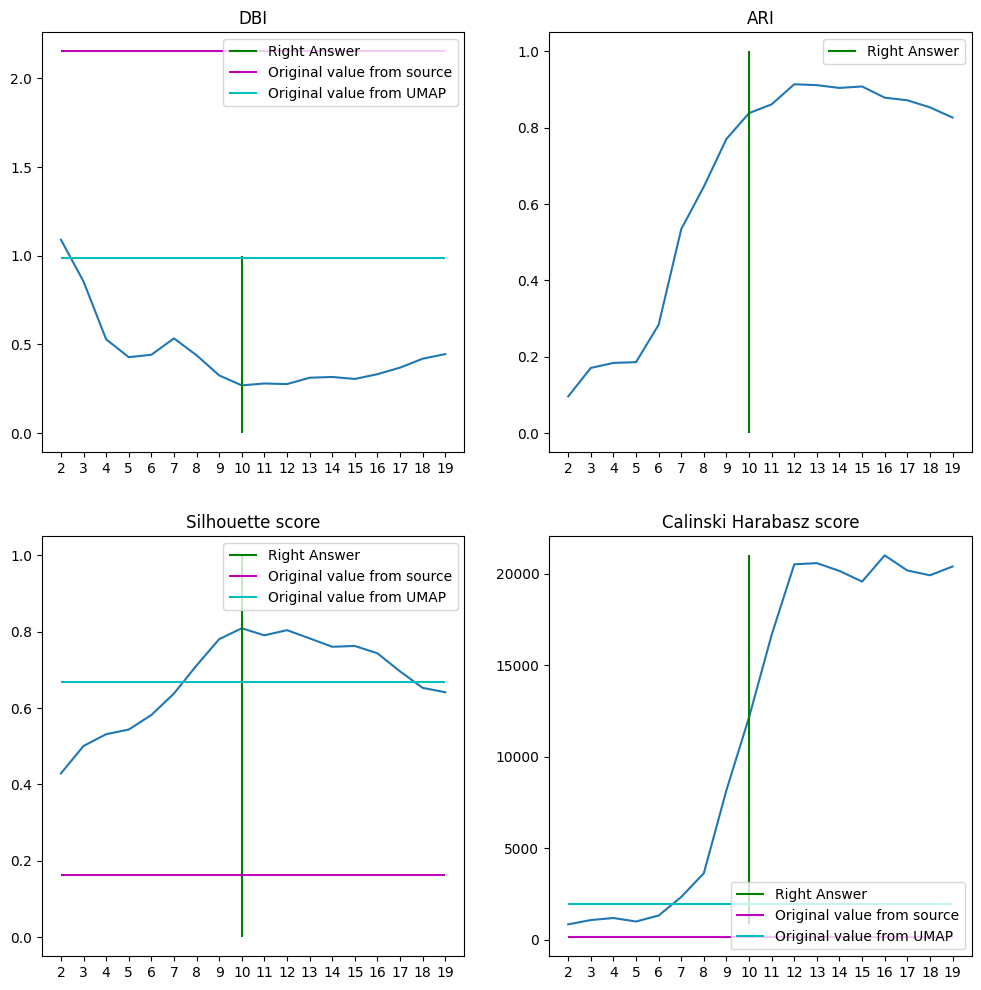

In [ ]:
fig, plots = plt.subplots(2, 2, figsize=(12,12))
k_range = np.arange(2, 20)

plots[0, 0].plot(k_range, dbi_scores)
plots[0, 1].plot(k_range, ari_scores)
plots[1, 0].plot(k_range, silhouette_scores)
plots[1, 1].plot(k_range, calinski_harabasz_scores)

plots[0, 0].set_title('DBI')
plots[0, 1].set_title('ARI')
plots[1, 0].set_title('Silhouette score')
plots[1, 1].set_title('Calinski Harabasz score')

plots[0, 0].vlines(10, 0, 1, color='g', label='Right Answer')
plots[0, 1].vlines(10, 0, 1, color='g', label='Right Answer')
plots[1, 0].vlines(10, 0, 1, color='g', label='Right Answer')
plots[1, 1].vlines(10, np.min(calinski_harabasz_scores), np.max(calinski_harabasz_scores), color='g', label='Right Answer')

plots[0, 0].hlines(dbi_orig, 2, 19, color='m', label='Original value from source')
plots[1, 0].hlines(silhouette_orig, 2, 19, color='m', label='Original value from source')
plots[1, 1].hlines(calinski_harabasz_orig, 2, 19, color='m', label='Original value from source')

plots[0, 0].hlines(dbi_umap, 2, 19, color='c', label='Original value from UMAP')
plots[1, 0].hlines(silhouette_umap, 2, 19, color='c', label='Original value from UMAP')
plots[1, 1].hlines(calinski_harabasz_umap, 2, 19, color='c', label='Original value from UMAP')

plots[0, 0].set_xticks(k_range)
plots[0, 1].set_xticks(k_range)
plots[1, 0].set_xticks(k_range)
plots[1, 1].set_xticks(k_range)

plots[0, 0].legend(loc='best')
plots[0, 1].legend(loc='best')
plots[1, 0].legend(loc='best')
plots[1, 1].legend(loc='best')

plt.show()

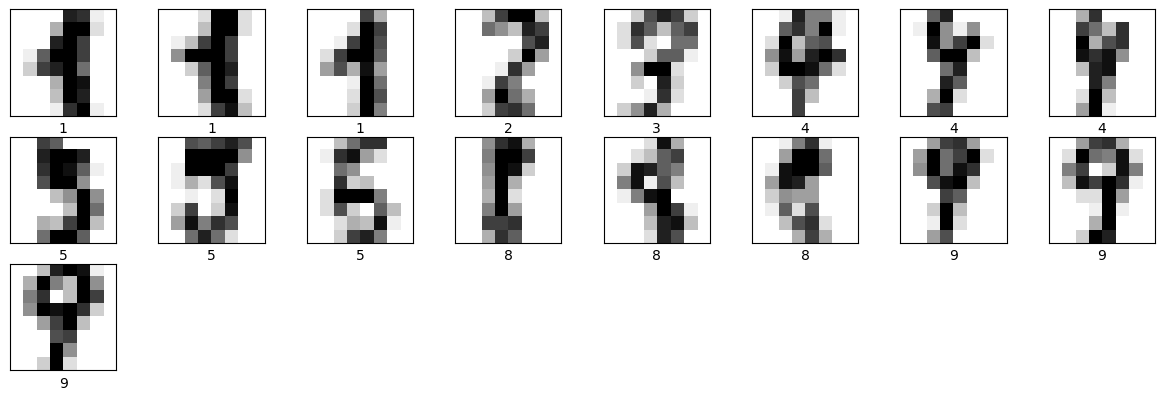

In [ ]:
from collections import Counter

plt.figure(figsize=(15, 8))
max_repeats = 3
images_count = 0

for i in range(10):
  class_predictions = y_pred_best[(y_true == i)]
  common_label = Counter(class_predictions).most_common()[0][0]
  repeats = 0
  for j in range(len(y_pred_best)):
    if y_true[j] == i and y_pred_best[j] != common_label:
      images_count += 1
      plt.subplot(5, 8, images_count)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(np.array(X.iloc[j]).reshape((8, 8)), cmap=plt.cm.binary)
      plt.xlabel(y_true[j])

      repeats += 1
      if repeats == max_repeats:
        break

plt.show()

In [ ]:
from hdbscan import HDBSCAN

y_pred = HDBSCAN().fit_predict(umap_3d_embeddings)

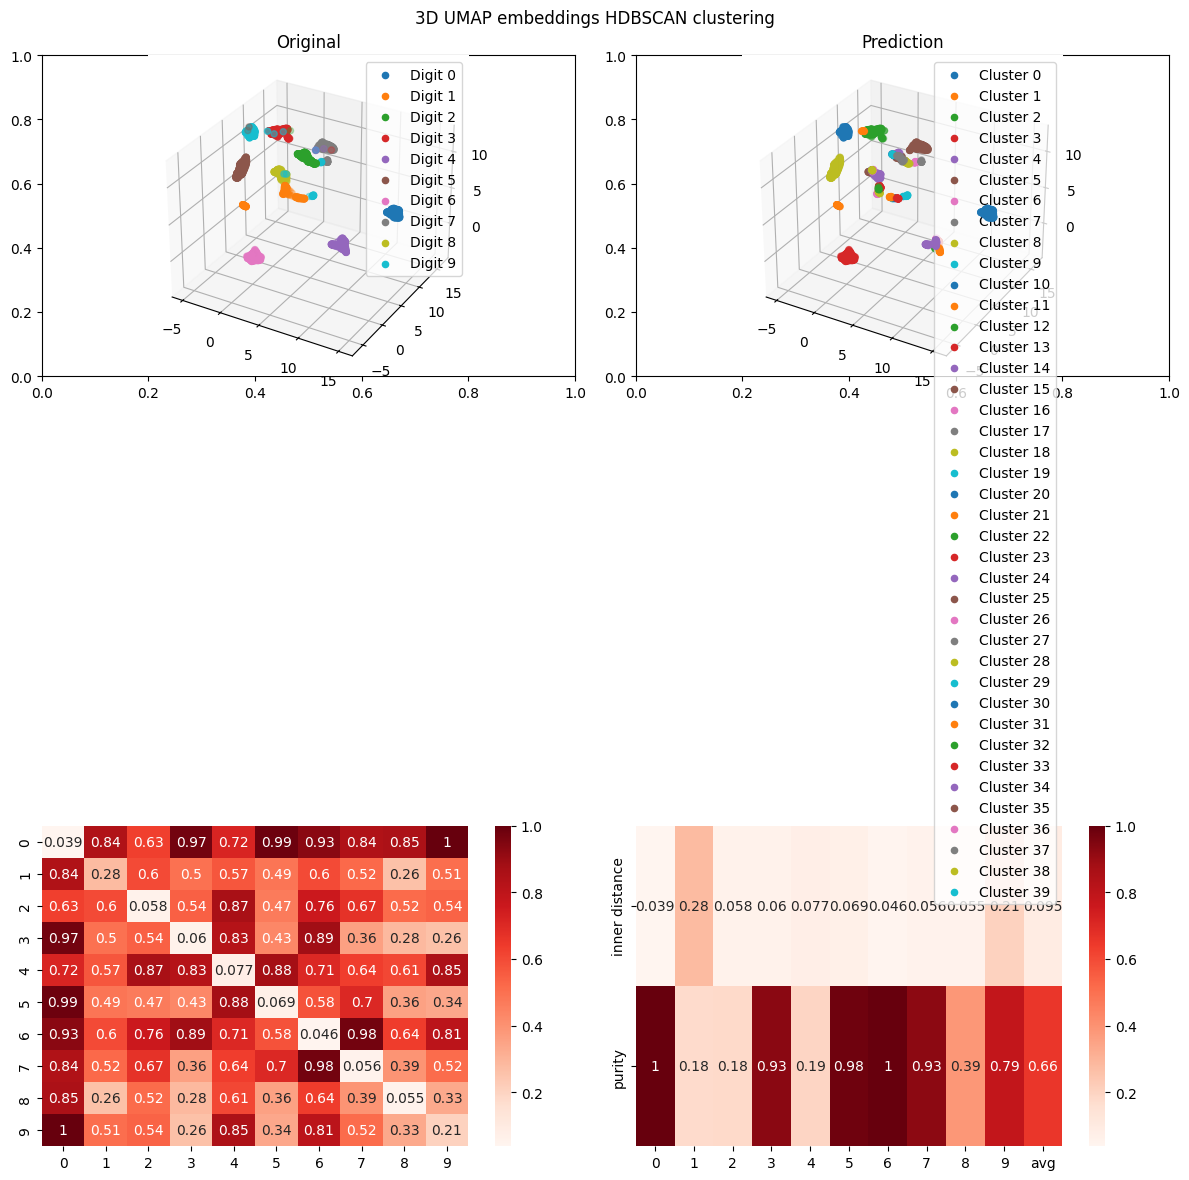

In [ ]:
plot_clustering('3D UMAP embeddings HDBSCAN clustering', umap_3d_embeddings, y_true, y_pred, 'euclidean')

In [ ]:
def custom_ari(estimator, X):
    labels = estimator.fit_predict(X)

    core_samples_mask = np.zeros_like(labels, dtype=bool)
    core_samples_mask[estimator.labels_ >= 0] = True

    if not np.any(core_samples_mask):
        return 0.0

    true_labels = y_true[core_samples_mask]
    labels = labels[core_samples_mask]

    return adjusted_rand_score(true_labels, labels)

def custom_dbi(estimator, X):
    labels = estimator.fit_predict(X)

    core_samples_mask = np.zeros_like(labels, dtype=bool)
    core_samples_mask[estimator.labels_ >= 0] = True

    if not np.any(core_samples_mask):
        return 0.0

    true_labels = y_true[core_samples_mask]
    labels = labels[core_samples_mask]

    return -davies_bouldin_score(X[core_samples_mask], labels)

def coverage(estimator, X):
    labels = estimator.fit_predict(X)

    core_samples_mask = np.zeros_like(labels, dtype=bool)
    core_samples_mask[estimator.labels_ >= 0] = True

    return np.mean(core_samples_mask)

In [ ]:
from sklearn.model_selection import GridSearchCV

def estimate_hdbscan(refit):
  param_grid = {
    'min_cluster_size': np.arange(1, 200, 2),
    'min_samples': np.arange(1, 25, 1),
    'metric': ['euclidean', 'manhattan', 'cosine']
  }
  hdb = HDBSCAN()
  grid_search = GridSearchCV(hdb, param_grid, scoring={'ARI': custom_ari, 'DBI': custom_dbi, 'coverage': coverage}, refit=refit)
  grid_search.fit(umap_3d_embeddings)

  best_params = grid_search.best_params_

  y_pred = HDBSCAN(min_cluster_size = grid_search.best_params_['min_cluster_size'],
                  min_samples = grid_search.best_params_['min_samples'],
                  metric = grid_search.best_params_['metric']).fit_predict(umap_3d_embeddings)

  return best_params, y_pred

In [ ]:
def visualize_dbscan(best_params, y_pred):
  print(f"Best parameters: {best_params}")
  core_samples_mask = np.zeros_like(y_pred, dtype=bool)
  core_samples_mask[y_pred >= 0] = True
  cov = np.mean(core_samples_mask)

  print(f"ARI: {adjusted_rand_score(y_true, y_pred)}")
  print(f"DBI: {davies_bouldin_score(umap_3d_embeddings, y_pred)}")
  print(f"ARI (covered): {adjusted_rand_score(y_true[core_samples_mask], y_pred[core_samples_mask])}")
  print(f"DBI (covered): {davies_bouldin_score(umap_3d_embeddings[core_samples_mask], y_pred[core_samples_mask])}")
  print(f"Coverage: {cov}")
  print(f"N clusters: {len(np.unique(y_pred))}")
  plot_clustering('3D UMAP embeddings HDBSCAN clustering', umap_3d_embeddings, y_true, y_pred, 'euclidean')

Best parameters: {'metric': 'euclidean', 'min_cluster_size': np.int64(73), 'min_samples': np.int64(2)}
ARI: 0.9356108582395702
DBI: 1.108035437257727
ARI (covered): 0.9623259010190077
DBI (covered): 0.2932566784292819
Coverage: 0.9738452977184195
N clusters: 11


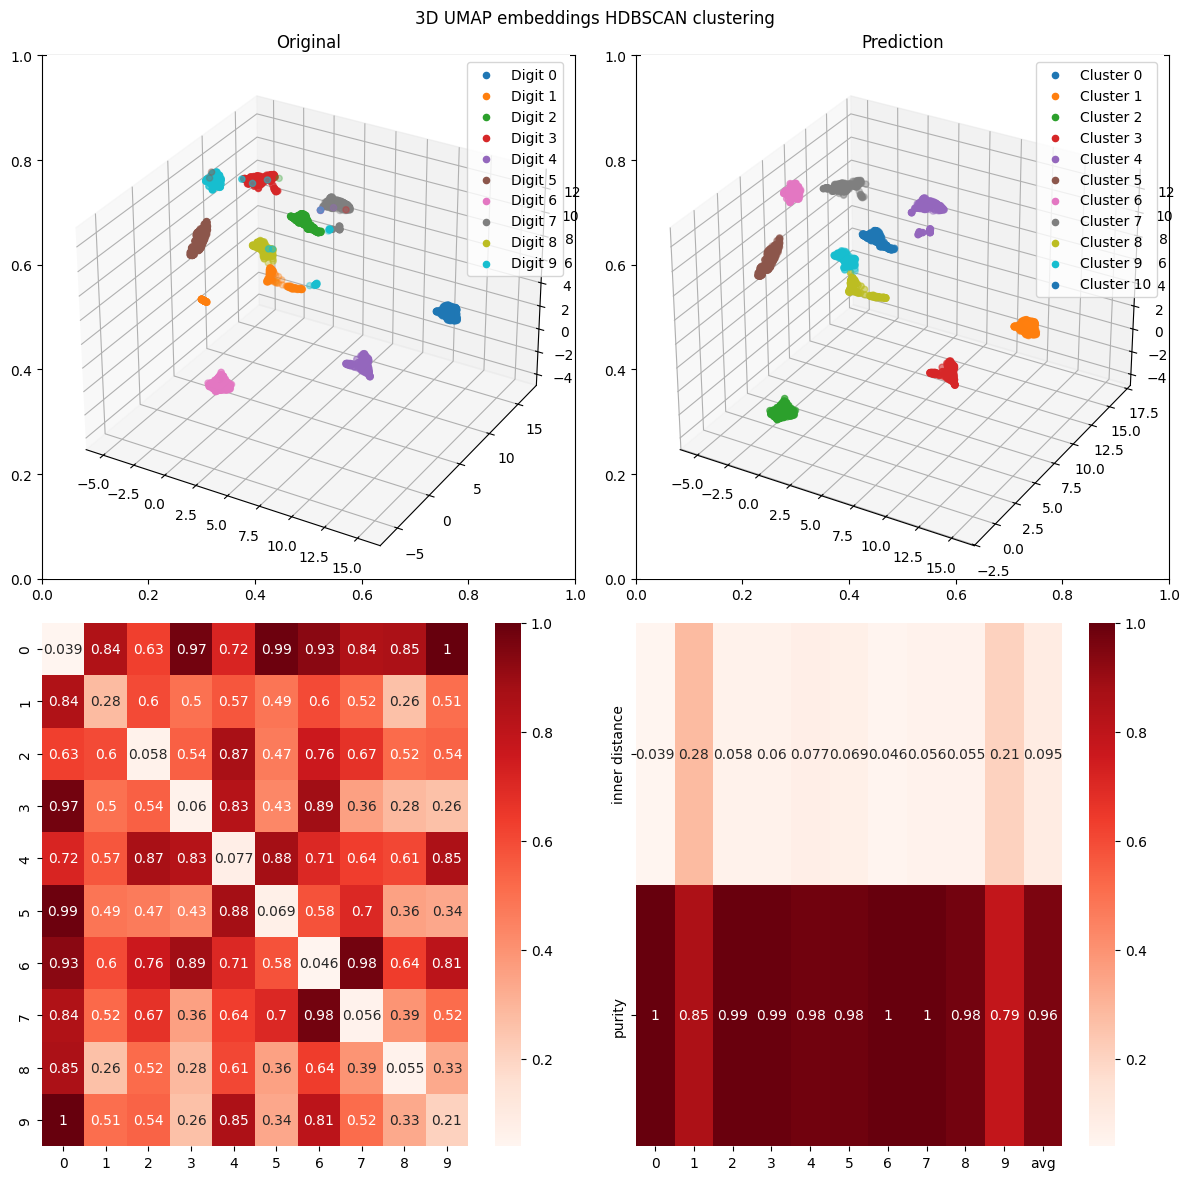

In [ ]:
best_params, y_pred = estimate_hdbscan('ARI')
visualize_dbscan(best_params, y_pred)

Best parameters: {'metric': 'euclidean', 'min_cluster_size': np.int64(73), 'min_samples': np.int64(2)}
ARI: 0.9356108582395702
DBI: 1.108035437257727
ARI (covered): 0.9623259010190077
DBI (covered): 0.2932566784292819
Coverage: 0.9738452977184195
N clusters: 11


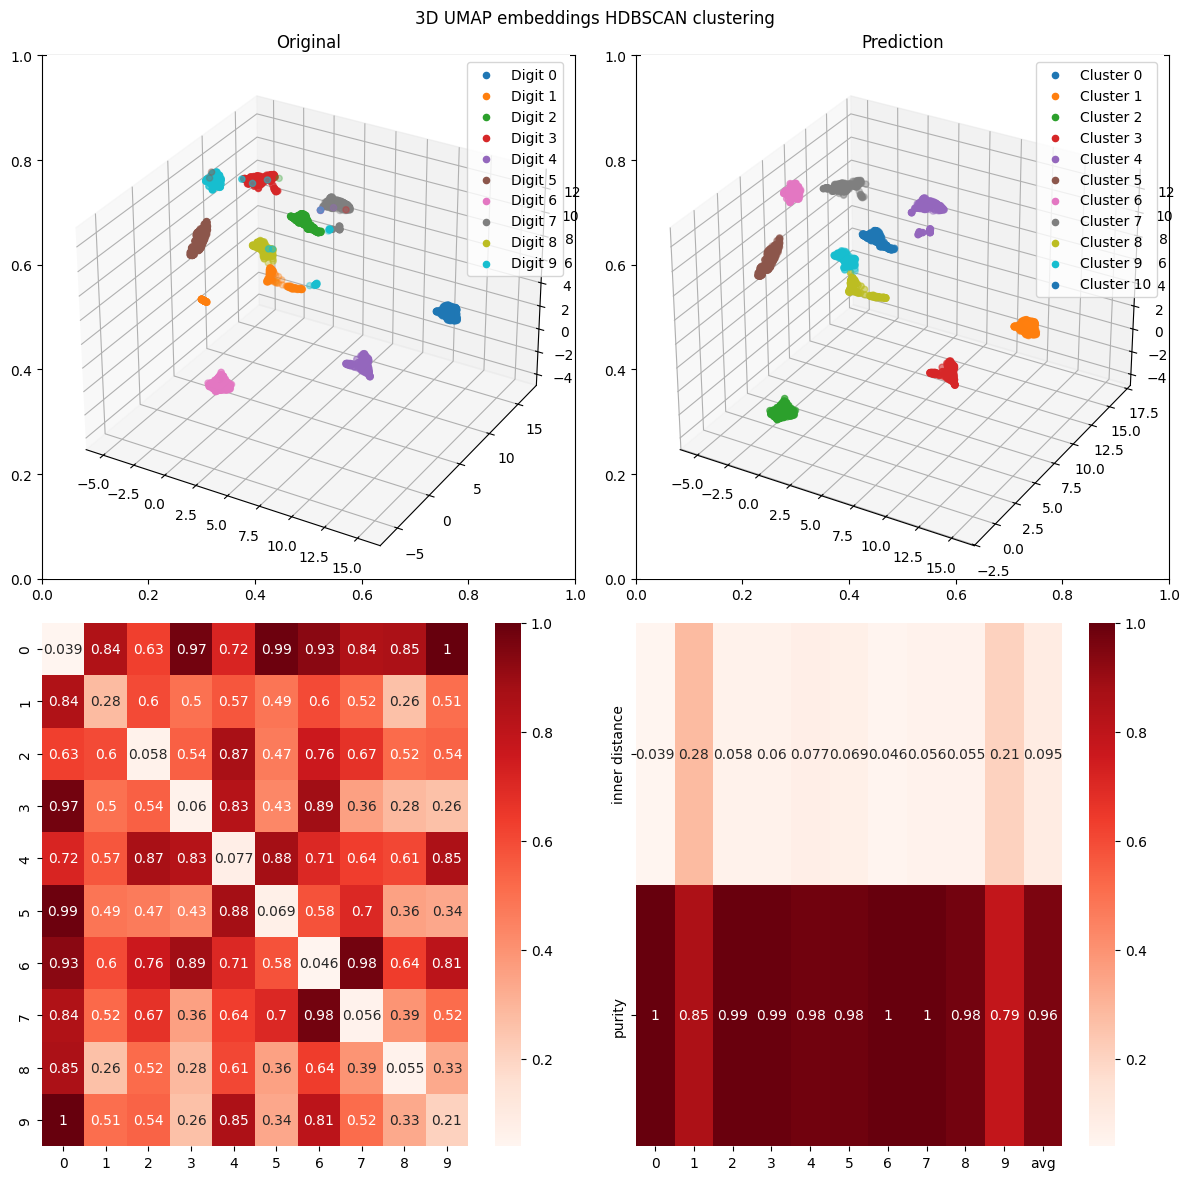

In [ ]:
best_params, y_pred = estimate_hdbscan('DBI')
visualize_dbscan(best_params, y_pred)

Best parameters: {'metric': 'manhattan', 'min_cluster_size': np.int64(25), 'min_samples': np.int64(1)}
ARI: 0.9176122329727908
DBI: 0.26678139414004515
ARI (covered): 0.9281580802532116
DBI (covered): 0.2659250879393454
Coverage: 0.9888703394546466
N clusters: 13


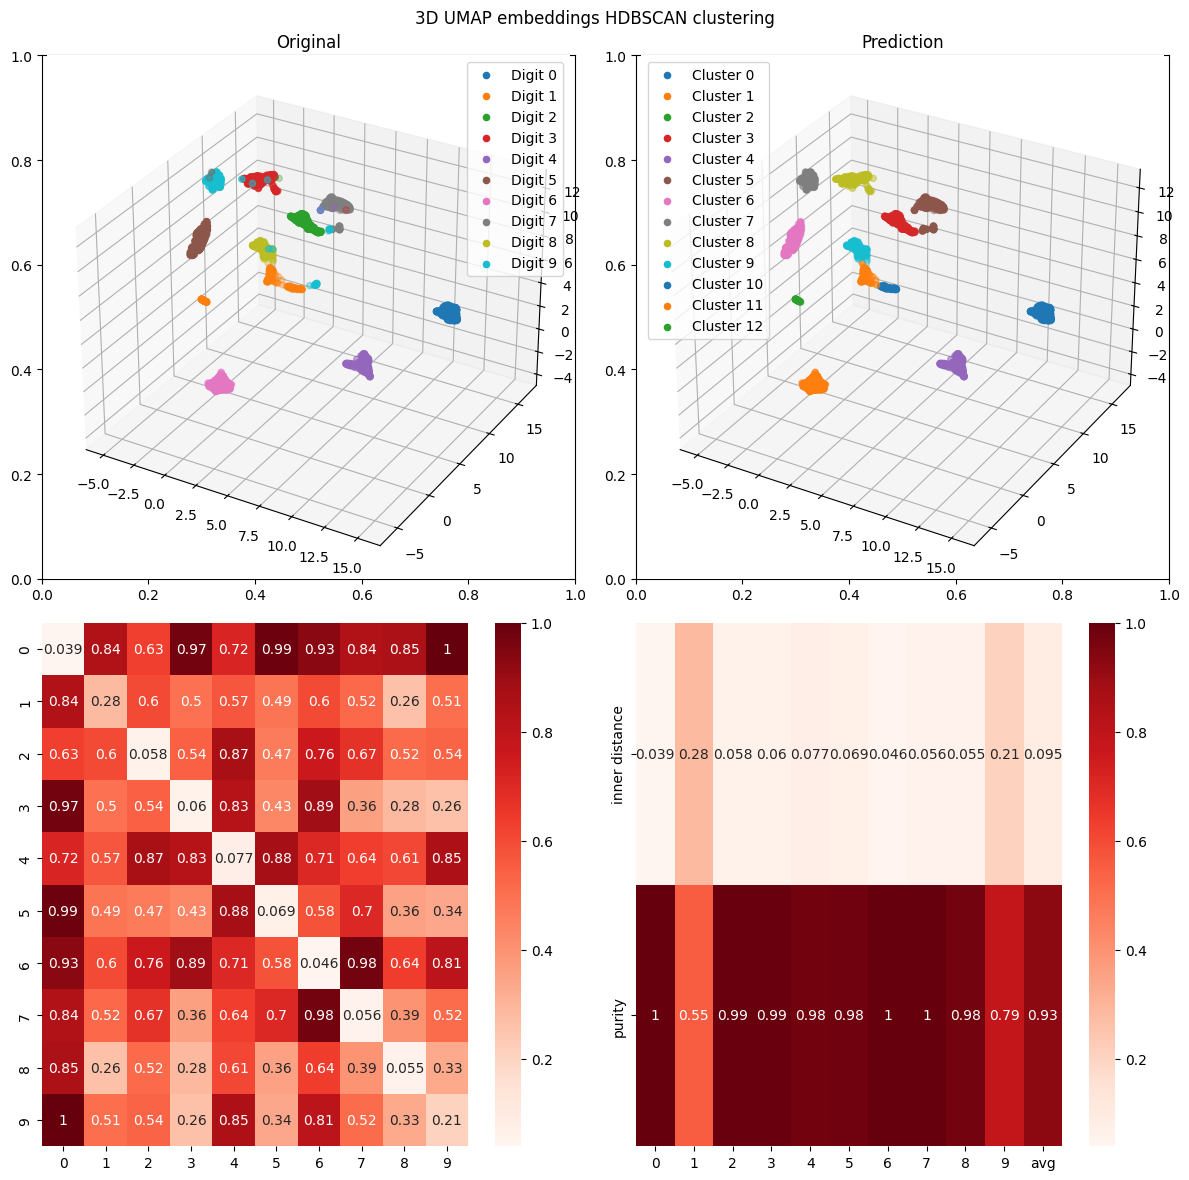

In [ ]:
best_params, y_pred = estimate_hdbscan('coverage')
visualize_dbscan(best_params, y_pred)

Полезные ссылки:
- https://umap-learn.readthedocs.io/en/latest/clustering.html
- https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html